In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [47]:
# Create list of all targets (minus background noise)
dataset_path = '/content/drive/MyDrive/datasets1sfinal'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
#all_targets.remove('_background_noise_')
all_targets.remove('PawnToSOLO')

all_targets.sort()
print(all_targets)

['eight', 'dog', 'down', 'backward', 'bird', 'bed', 'forward', 'five', 'follow', 'cat', 'no', 'house', 'four', 'learn', 'go', 'nine', 'off', 'left', 'marvin', 'happy', 'stop', 'three', 'on', 'six', 'seven', 'two', 'right', 'tree', 'sheila', 'one', 'up', 'PawnToSOLOmulti']


In [50]:
# Settings
feature_sets_path = '/content/drive/MyDrive/datasets1sfinal'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = '/content/drive/MyDrive/datasets1sfinal/wake_word_pawnto_model.h5'
wake_word = 'PawnToSOLOmulti'

In [51]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [52]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [53]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(6983, 16, 16)
(864, 16, 16)
(868, 16, 16)


In [54]:
# Peek at labels
print(y_val)

[15. 23.  2. 16.  3.  1. 24. 21.  4. 25. 28. 23. 25.  1. 11. 31. 15. 21.
 30.  0.  0. 15.  1. 11.  8. 25.  1. 23.  8. 24.  8. 29. 26. 22.  6.  0.
  2. 30. 19. 18. 15.  2.  6. 16.  0. 29.  6.  3. 17.  5. 20. 13. 21. 16.
 27.  0. 17. 11.  8. 24. 17. 30. 29. 24. 22. 18. 23.  3.  7. 19. 17. 14.
  0. 28. 17. 20. 11.  8.  3. 23. 29. 23. 18. 18. 21.  3. 15. 21.  3. 26.
 21. 29. 26. 15. 19. 24. 15.  8. 13. 17. 17. 11. 14. 22.  1. 11.  0. 17.
 11.  8.  6. 11. 11. 23. 18. 25. 23.  0. 31.  9.  6. 12.  0. 21. 26. 15.
 12. 10.  8. 10. 23.  8. 12. 22. 22.  3. 11.  2. 18. 12. 30. 30. 29. 30.
  1.  3. 11. 30. 17. 24.  8. 14. 16. 14. 14. 17.  1. 12.  3.  5. 15. 26.
  9. 29. 22. 24. 23.  9. 16. 26. 10. 26. 17. 25.  3. 14. 10. 15.  8.  8.
 10. 22.  3. 16. 22.  3. 30. 20. 16.  7. 10.  3. 10. 26. 25. 14. 22. 30.
 21. 26. 10.  5. 10. 23. 31.  2. 11. 24.  1. 15.  3. 18. 23. 29. 16.  1.
  0. 30.  0. 25. 13. 24. 18. 28. 18. 14. 24. 10. 20. 29. 22. 13. 27.  3.
 11. 15. 15. 17. 13.  3. 21. 12. 13. 22. 26. 18.  3

In [61]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')
print('index: '+ str(wake_word_index))

index: 31


In [38]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [39]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.0
1.0


In [40]:
# View the dimensions of our input data
print(x_train.shape)

(6983, 16, 16, 1)


In [33]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(6983, 16, 16, 1)
(864, 16, 16, 1)
(868, 16, 16, 1)


In [16]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [17]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 15, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 32)          4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [19]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [20]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
70/70 [==============================] - 3s 26ms/step - loss: 0.0277 - acc: 0.9887 - val_loss: 3.4119e-07 - val_acc: 1.0000
Epoch 2/30
70/70 [==============================] - 1s 21ms/step - loss: 2.7866e-05 - acc: 1.0000 - val_loss: 8.2211e-10 - val_acc: 1.0000
Epoch 3/30
70/70 [==============================] - 2s 24ms/step - loss: 1.6003e-07 - acc: 1.0000 - val_loss: 3.7944e-12 - val_acc: 1.0000
Epoch 4/30
70/70 [==============================] - 2s 22ms/step - loss: 5.6500e-09 - acc: 1.0000 - val_loss: 1.4238e-13 - val_acc: 1.0000
Epoch 5/30
70/70 [==============================] - 2s 23ms/step - loss: 1.9724e-09 - acc: 1.0000 - val_loss: 3.7744e-14 - val_acc: 1.0000
Epoch 6/30
70/70 [==============================] - 2s 24ms/step - loss: 9.3404e-09 - acc: 1.0000 - val_loss: 5.8385e-16 - val_acc: 1.0000
Epoch 7/30
70/70 [==============================] - 2s 22ms/step - loss: 1.2084e-11 - acc: 1.0000 - val_loss: 5.6918e-16 - val_acc: 1.0000
Epoch 8/30
70/70 [=============

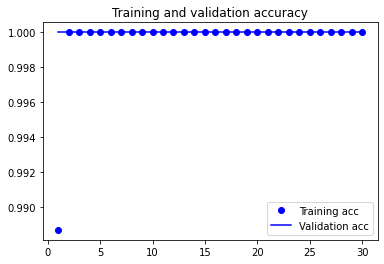

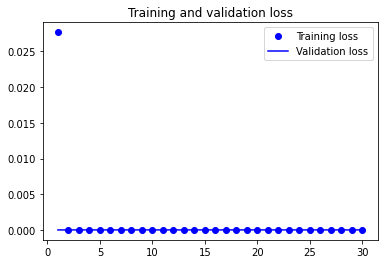

In [21]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
# Save the model as a file
models.save_model(model, model_filename)

In [23]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

In [ ]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(10, 20):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]
Answer: 1.0  Prediction: [[1.]]


In [ ]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

4/4 [==============================] - 0s 4ms/step - loss: 8.0287e-10 - acc: 1.0000


[8.028742670695976e-10, 1.0]